# CAPM model simplified

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

## Download history data

In [2]:
# Download stock 
tickers = ["SPY", "AAPL", "META", "NVDA", "AMZN"]

from_time = "2023-01-01"
to_time = "2024-06-15"

historical_data = yf.download(tickers, from_time, to_time)

historical_data

C:\Users\Admin\AppData\Local\Temp\ipykernel_5900\2804792590.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  historical_data = yf.download(tickers, from_time, to_time)
[*********************100%***********************]  5 of 5 completed


Price            Close                                                  \
Ticker            AAPL        AMZN        META        NVDA         SPY   
Date                                                                     
2023-01-03  123.470619   85.820000  124.059410   14.302287  368.168671   
2023-01-04  124.744118   85.139999  126.675049   14.735900  371.011017   
2023-01-05  123.421257   83.120003  126.247398   14.252333  366.776520   
2023-01-06  127.962425   86.080002  129.310577   14.845804  375.187469   
2023-01-09  128.485626   87.360001  128.763580   15.614120  374.974792   
...                ...         ...         ...         ...         ...   
2024-06-10  192.221024  187.059998  500.388092  121.741539  527.368896   
2024-06-11  206.185715  187.229996  505.236664  120.871819  528.639038   
2024-06-12  212.078201  186.889999  506.600647  125.160461  532.980774   
2024-06-13  213.242737  183.830002  501.881531  129.569061  534.053894   
2024-06-14  211.500870  183.660004  502.439636  131.838364  534.378845   

Price             High                                                  ...  \
Ticker            AAPL        AMZN        META        NVDA         SPY  ...   
Date                                                                    ...   
2023-01-03  129.226060   86.959999  125.680522   14.982683  373.592285  ...   
2023-01-04  127.014709   86.980003  128.345883   14.839808  373.060583  ...   
2023-01-05  126.136090   85.419998  127.818779   14.551067  369.154787  ...   
2023-01-06  128.623856   86.400002  129.618884   14.996670  376.318614  ...   
2023-01-09  131.703947   89.480003  132.224588   16.041739  380.620806  ...   
...                ...         ...         ...         ...         ...  ...   
2024-06-10  196.381574  187.229996  500.447826  123.051015  527.693805  ...   
2024-06-11  206.195678  187.770004  505.366097  122.831199  528.698107  ...   
2024-06-12  219.175002  188.350006  511.747908  126.839931  535.698064  ...   
2024-06-13  215.741048  187.669998  507.118362  129.759004  534.920278  ...   
2024-06-14  214.168387  183.720001  505.419424  132.798052  534.408350  ...   

Price             Open                                                  \
Ticker            AAPL        AMZN        META        NVDA         SPY   
Date                                                                     
2023-01-03  128.613993   85.459999  122.149888   14.837811  371.600723   
2023-01-04  125.267339   86.550003  126.684989   14.554062  370.450269   
2023-01-05  125.504275   85.330002  125.441813   14.478132  369.038778   
2023-01-06  124.398597   83.029999  128.266303   14.461146  369.899189   
2023-01-09  128.801541   87.459999  130.444362   15.270425  377.401417   
...                ...         ...         ...         ...         ...   
2024-06-10  195.983426  184.070007  491.686536  120.322106  524.927302   
2024-06-11  192.748557  187.059998  497.958837  121.731540  525.803610   
2024-06-12  206.404722  188.020004  511.727976  123.021138  533.246614   
2024-06-13  213.740409  186.089996  503.484431  129.349130  534.743071   
2024-06-14  212.854540  183.080002  500.934779  129.918972  532.508230   

Price          Volume                                            
Ticker           AAPL      AMZN      META       NVDA        SPY  
Date                                                             
2023-01-03  112117500  76706000  35528500  401277000   74850700  
2023-01-04   89113600  68885100  32397100  431324000   85934100  
2023-01-05   80962700  67930800  25447100  389168000   76970500  
2023-01-06   87754700  83303400  27584500  405044000  104189600  
2023-01-09   70790800  65266100  26649100  504231000   73978100  
...               ...       ...       ...        ...        ...  
2024-06-10   97010200  34445600  11220900  313434100   35686100  
2024-06-11  172373300  27265100   9673700  222551200   36383400  
2024-06-12  198134300  33984200  11983200  299595000   63251300  
2024-06-13   97862700  3972

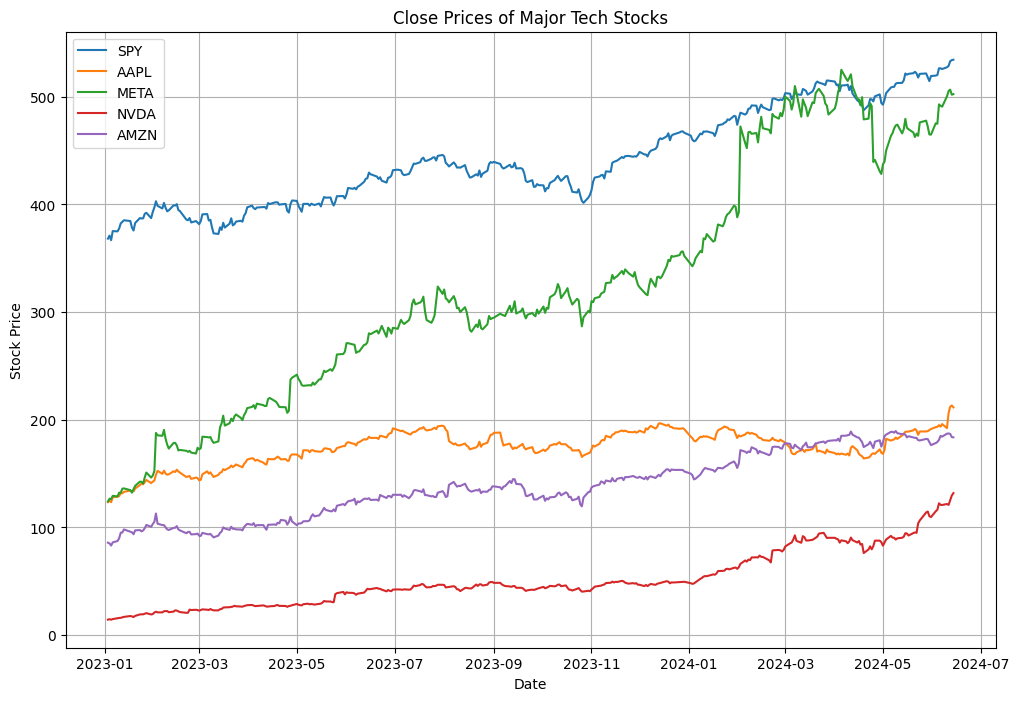

In [3]:
# Plotting Adj Close prices of the stock with legend for each stock
plt.figure(figsize=(12, 8))

for ticker in tickers:
    plt.plot(historical_data['Close'][ticker], label=ticker)

# Adding title and labels
plt.title('Close Prices of Major Tech Stocks')
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.grid(True)
plt.legend()

plt.show()

,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,365.0,174.051566,16.216501,123.421257,167.438782,176.037216,186.643188,213.242737
AMZN,365.0,138.082904,29.898211,83.120003,112.910004,134.910004,168.589996,189.500000
META,365.0,323.387073,110.293719,124.059410,239.008774,307.652191,430.716064,525.019226
NVDA,365.0,51.456182,26.006947,14.252333,29.130056,45.482761,67.441994,131.838364
SPY,365.0,442.223515,44.885201,366.776520,401.909790,433.652374,484.827759,534.378845


<Figure size 1200x800 with 0 Axes>

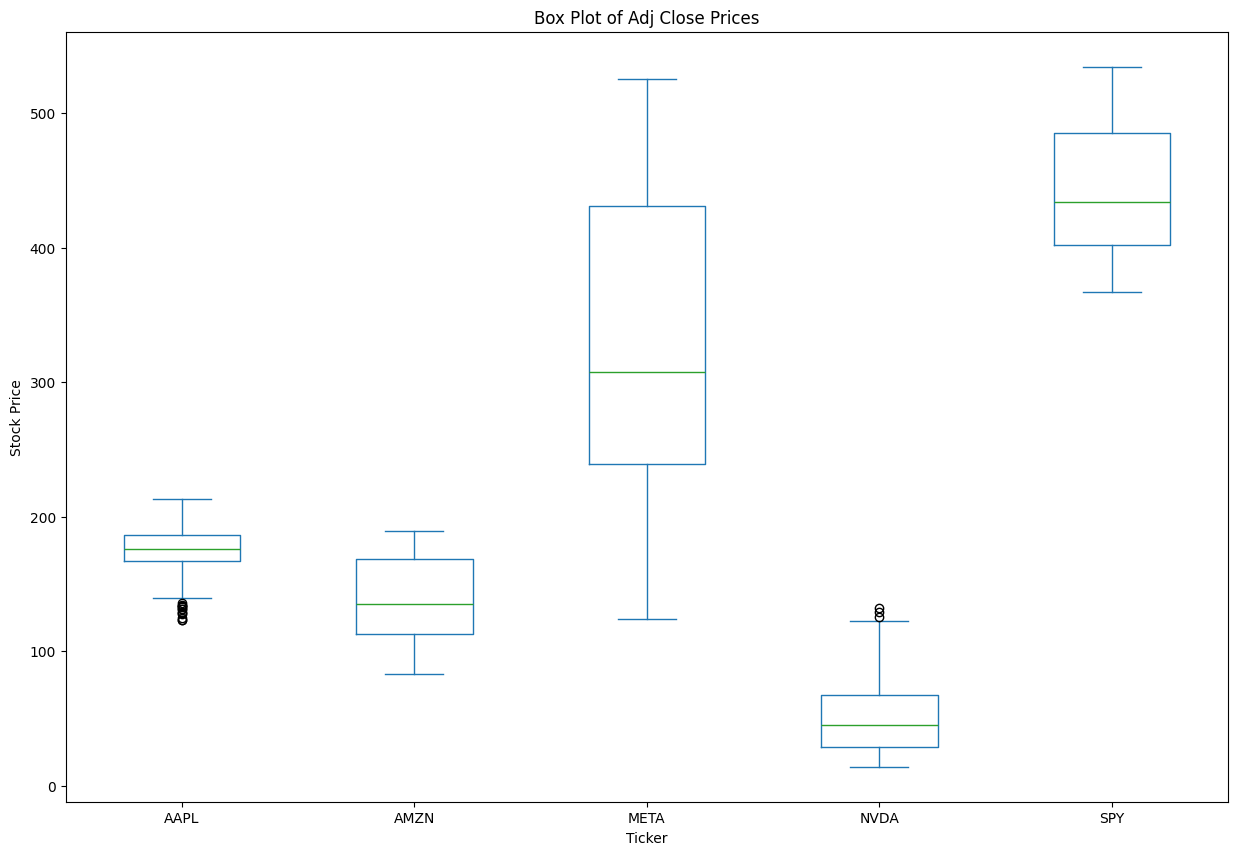

In [4]:
# Calculate mean, median, mode, standard deviation, variance, skewness, and kurtosis
stats_metrics = historical_data['Close'].describe().T

# display the statistics metrics
display(stats_metrics)

# show Box Plot of Close prices of the stock ( show Mean, Median, 1st Quartile, 3rd Quartile, Max, Min, Outliers)
plt.figure(figsize=(12, 8))
historical_data['Close'].plot(kind='box', figsize=(15, 10))
plt.title('Box Plot of Adj Close Prices')
plt.ylabel('Stock Price')
plt.xlabel('Ticker')

plt.show()

<Figure size 1200x800 with 0 Axes>

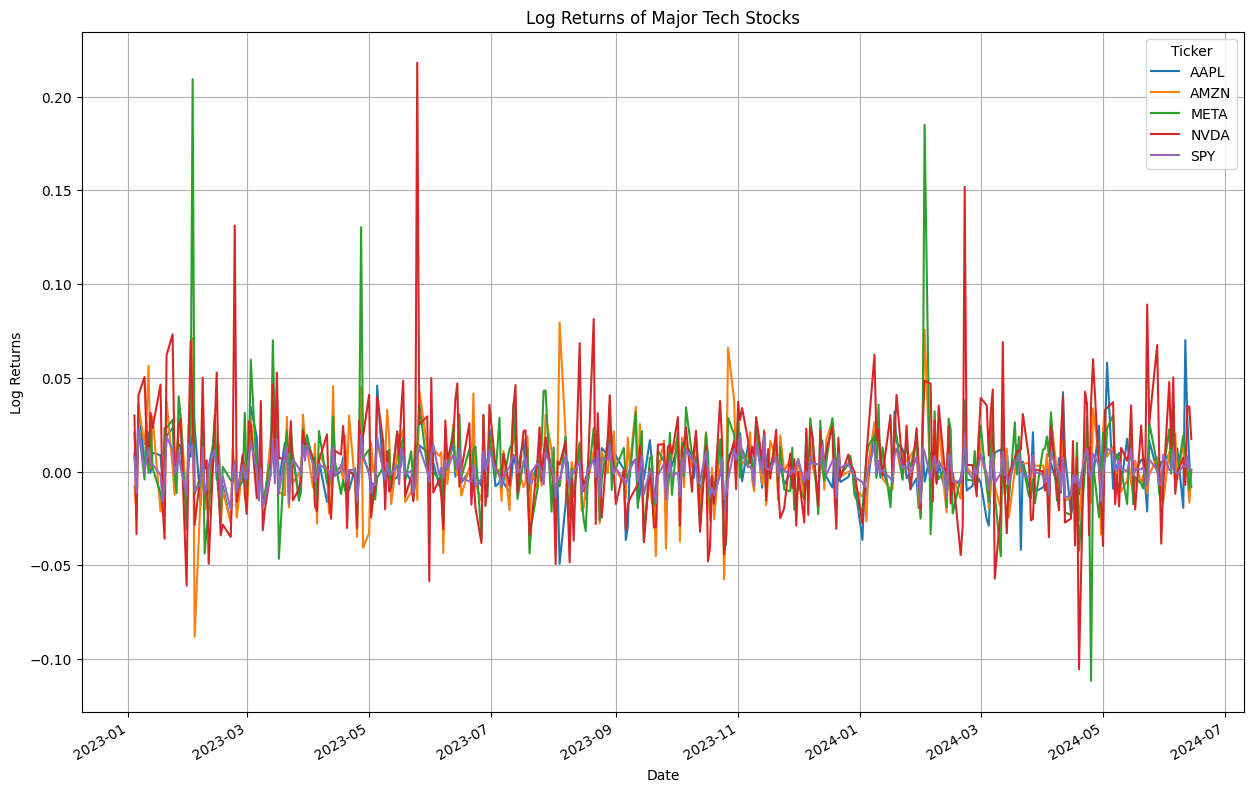

In [5]:
log_returns = np.log(historical_data['Close'] / historical_data['Close'].shift(1))

# drop NaN values
log_returns.dropna(inplace=True)

# plot Log Returns of the stock
plt.figure(figsize=(12, 8))
log_returns.plot(figsize=(15, 10))
plt.title('Log Returns of Major Tech Stocks')
plt.ylabel('Log Returns')
plt.xlabel('Date')
plt.grid(True)
plt.show()

### Calculate
- expected return
- covariance
- variance
- beta coefficient
- jensens alpha

In [6]:
# risk free rate, for now 4% per annum
risk_free_rate = 0.0138

# calculate annualized mean returns
mean_returns = log_returns.mean() * 252

# calculate covariance matrix
cov_matrix = log_returns.cov()

# calculate annualized std
std = log_returns.std() * np.sqrt(252)

# calculate beta coefficient = cov / std of SPY
beta_coefficients = cov_matrix["SPY"].div(log_returns["SPY"].var(), axis=0)

# calculate expected returns using CAPM
expected_returns = risk_free_rate + beta_coefficients * (mean_returns["SPY"] - risk_free_rate)

# calculate jensen's alpha, the abnormal return of the stock
jensen_alpha = mean_returns - expected_returns

--------------------------------------------------
Risk-Free Rate: 0.0138
--------------------------------------------------
Mean Returns of SPY: 0.25792882480952845
--------------------------------------------------
Covariance Matrix:


Ticker,AAPL,AMZN,META,NVDA,SPY
Ticker,,,,,
AAPL,0.000183,0.000097,0.000127,0.000138,0.000067
AMZN,0.000097,0.000367,0.000283,0.000240,0.000094
META,0.000127,0.000283,0.000609,0.000305,0.000111
NVDA,0.000138,0.000240,0.000305,0.000913,0.000132
SPY,0.000067,0.000094,0.000111,0.000132,0.000061


--------------------------------------------------
Standard Deviation:


Ticker
AAPL    0.214913
AMZN    0.304303
META    0.391899
NVDA    0.479580
SPY     0.124420
dtype: float64

--------------------------------------------------
Beta Coefficients:


Ticker
AAPL    1.088820
AMZN    1.530281
META    1.802253
NVDA    2.154900
SPY     1.000000
Name: SPY, dtype: float64

--------------------------------------------------


,Expected Returns,Mean Returns,Beta,Jensen's Alpha
Ticker,,,,
AAPL,0.279612,0.372618,1.088820,9.300568e-02
AMZN,0.387386,0.526731,1.530281,1.393455e-01
META,0.453782,0.968341,1.802253,5.145592e-01
NVDA,0.539873,1.537724,2.154900,9.978509e-01
SPY,0.257929,0.257929,1.000000,5.551115e-17


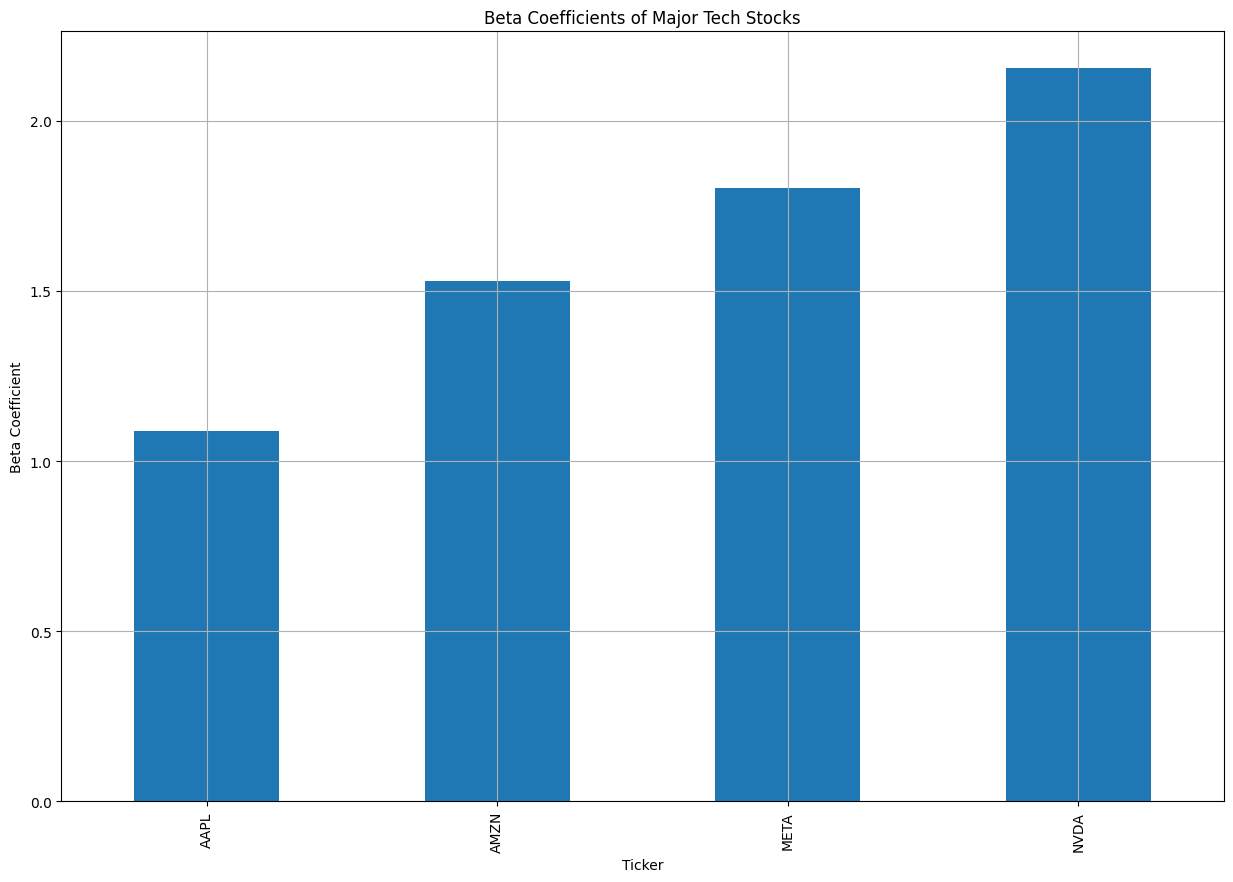

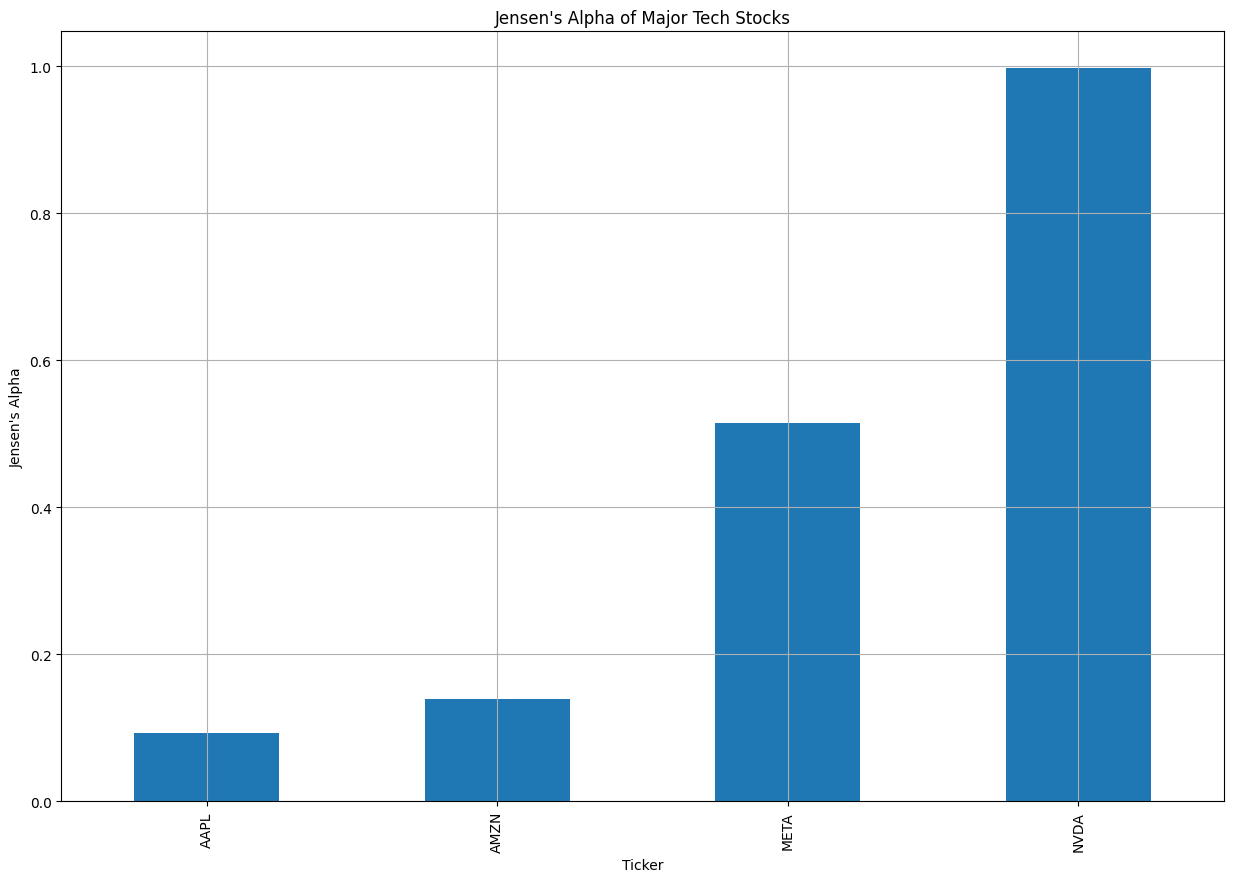

In [7]:
# print Risk-Free Rate, Mean returns of SPY
print('-'*50)
print('Risk-Free Rate:', risk_free_rate)
print('-'*50)
print('Mean Returns of SPY:', mean_returns['SPY'])

# display expected returns, covariance matrix, variance, and beta coefficients
print('-'*50)
print('Covariance Matrix:')
display(cov_matrix)
print('-'*50)
print('Standard Deviation:')
display(std)
print('-'*50)
print('Beta Coefficients:')
display(beta_coefficients)
print('-'*50)

# put expected returns & mean returns & Beta & Jensen's Alpha in a DataFrame
df_returns = pd.DataFrame([expected_returns, mean_returns, beta_coefficients, jensen_alpha], index=['Expected Returns', 'Mean Returns', 'Beta', "Jensen's Alpha"]).T
display(df_returns)

# plot beta coefficients ( remove SPY)
plt.figure(figsize=(12, 8))
df_returns['Beta'].drop('SPY').plot(kind='bar', figsize=(15, 10))
plt.title('Beta Coefficients of Major Tech Stocks')
plt.ylabel('Beta Coefficient')
plt.xlabel('Ticker')
plt.grid(True)

# plot Jensen's Alpha ( remove SPY)
plt.figure(figsize=(12, 8))
df_returns["Jensen's Alpha"].drop('SPY').plot(kind='bar', figsize=(15, 10))
plt.title('Jensen\'s Alpha of Major Tech Stocks')
plt.ylabel('Jensen\'s Alpha')
plt.xlabel('Ticker')
plt.grid(True)

# Efficient Frontier of portfolios (no risk free rate)
goal:
- max sharpe ratio
- min volatility
- min VaR

In [12]:
# num of simulations
num_simulations = 10000
risk_free_rate = 0.0138
confidence_level = 0.05 # 95% confidence level

# stock returns
stock_returns = log_returns.drop("SPY",axis=1)
stock_tickers = stock_returns.columns

# annualized mean returns
mean_returns = stock_returns.mean() * 252
# annualized covariance matrix
cov_matrix = stock_returns.cov() * 252

# calculate portfolio performance metrics
def calc_portfolio_perf(weights, mean_returns, cov_matrix, rf):
    # compute portfolio log return annualized
    portfolio_return = np.sum(mean_returns * weights)
    # compute portfolio std annualized
    portfolio_std = np.sqrt(weights.T @ cov_matrix @ weights)
    # compute sharpe ratio
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    # compute portfolio Value at Risk (VaR) using the normal distribution
    portfolio_var = norm.ppf(1 - confidence_level, portfolio_return, portfolio_std)
    return portfolio_return, portfolio_std, sharpe_ratio, portfolio_var

# prepare monte carlo simulation
results = np.zeros((len(stock_tickers)+1, num_simulations))
weights_record = []

# randomize weights and calculate portfolio performance metrics
for i in range(num_simulations):
    weights = np.random.random(len(stock_tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_return, portfolio_std, sharpe_ratio, portfolio_var = calc_portfolio_perf(weights, mean_returns, cov_matrix, risk_free_rate)
    results[0, i] = portfolio_return
    results[1, i] = portfolio_std
    results[2, i] = sharpe_ratio
    results[3, i] = portfolio_var

results[4] = np.arange(num_simulations)

# get the indices of the optimal portfolios
max_sharpe_idx = np.argmax(results[2])
min_vol_idx = np.argmin(results[1])
min_var_idx = np.argmin(results[3])

# get portfolio metrics for the optimal portfolios
max_sharpe_port = results[:, max_sharpe_idx]
min_vol_port = results[:, min_vol_idx]
min_var_port = results[:, min_var_idx]

# get the weights for the optimal portfolios using simulation index
max_sharpe_weights = weights_record[int(max_sharpe_port[4])]
min_vol_weights = weights_record[int(min_vol_port[4])]
min_var_weights = weights_record[int(min_var_port[4])]


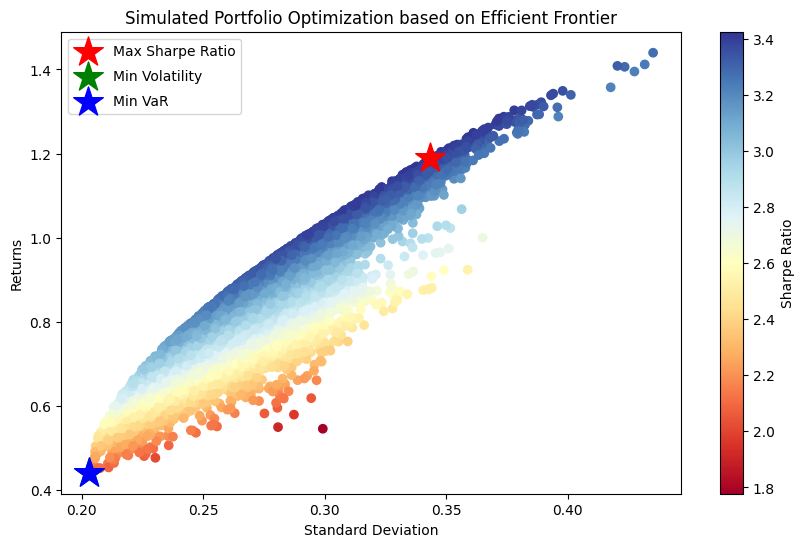

Max Sharpe Ratio Portfolio Allocation

Annualised Return: 1.19
Annualised Volatility: 0.34
Sharpe Ratio: 3.42
Weights: {'AAPL': np.float64(0.13786855925034064), 'AMZN': np.float64(0.002864489909535554), 'META': np.float64(0.32463401552133375), 'NVDA': np.float64(0.53463293531879)}


Min Volatility Portfolio Allocation

Annualised Return: 0.44
Annualised Volatility: 0.2
Sharpe Ratio: 2.1
Weights: {'AAPL': np.float64(0.6924377424959681), 'AMZN': np.float64(0.2767444353614604), 'META': np.float64(0.017526847386441547), 'NVDA': np.float64(0.013290974756130104)}


Min VaR Portfolio Allocation

Annualised Return: 0.44
Annualised Volatility: 0.2
Sharpe Ratio: 2.1
Weights: {'AAPL': np.float64(0.6924377424959681), 'AMZN': np.float64(0.2767444353614604), 'META': np.float64(0.017526847386441547), 'NVDA': np.float64(0.013290974756130104)}


In [13]:
# Visualize the efficient frontiers
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='RdYlBu', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_port[1], max_sharpe_port[0], marker='*', color='r', s=500, label='Max Sharpe Ratio')
plt.scatter(min_vol_port[1], min_vol_port[0], marker='*', color='g', s=500, label='Min Volatility')
plt.scatter(min_var_port[1], min_var_port[0], marker='*', color='b', s=500, label='Min VaR')
plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.legend(labelspacing=0.8)
plt.show()

print("Max Sharpe Ratio Portfolio Allocation\n")
print("Annualised Return:", round(max_sharpe_port[0], 2))
print("Annualised Volatility:", round(max_sharpe_port[1], 2))
print("Sharpe Ratio:", round(max_sharpe_port[2], 2))
print("Weights:", dict(zip(stock_tickers, max_sharpe_weights)))
print("\n")

print("Min Volatility Portfolio Allocation\n")
print("Annualised Return:", round(min_vol_port[0], 2))
print("Annualised Volatility:", round(min_vol_port[1], 2))
print("Sharpe Ratio:", round(min_vol_port[2], 2))
print("Weights:", dict(zip(stock_tickers, min_vol_weights)))
print("\n")

print("Min VaR Portfolio Allocation\n")
print("Annualised Return:", round(min_var_port[0], 2))
print("Annualised Volatility:", round(min_var_port[1], 2))
print("Sharpe Ratio:", round(min_var_port[2], 2))
print("Weights:", dict(zip(stock_tickers, min_var_weights)))